In [58]:
import pandas as pd
import os
import math
from sklearn import linear_model
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf




TCGA_Data = pd.read_csv('TCGA_Data.csv')

VHL_Case_Mutations = pd.read_csv('VHL_Case_Mutations.csv')
PBRM1_Case_Mutations = pd.read_csv('PBRM1_Case_Mutations.csv')
TTN_Case_Mutations = pd.read_csv('TTN_Case_Mutations.csv')
MUC16_Case_Mutations = pd.read_csv('MUC16_Case_Mutations.csv')


TCGA_Data['Case UUID'] = TCGA_Data['Case UUID'].astype('string')

VHL_Case_Mutations['Case UUID'] = VHL_Case_Mutations['Case UUID'].astype('string')
PBRM1_Case_Mutations['Case UUID'] = PBRM1_Case_Mutations['Case UUID'].astype('string')
TTN_Case_Mutations['Case UUID'] = TTN_Case_Mutations['Case UUID'].astype('string')
MUC16_Case_Mutations['Case UUID'] = MUC16_Case_Mutations['Case UUID'].astype('string')




In [16]:
def print_whole_df(df):
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
        print(df)


def disp_hist(dataframe,ind_vars):
    '''
    Dataframe is a pandas dataframe, col_names is a list containing strings corresponding
    to the columns to create histograms of
    Does not return an object, just displays histograms
    '''
    for cur_ind_var in ind_vars:
        hist = dataframe.hist(cur_ind_var)

def df_to_numeric(dataframe,var):
    '''Returns the dataframe, with specific variables as numeric format, dropping non-numeric observations
    dataframe= dataframe
    var = string of column you wish to convert to numeric
    '''
    before_obs_num = len(dataframe)
    for cur_var in var:
        as_numeric_var = (pd.to_numeric((pd.Series(dataframe[var])),errors='coerce'))
        dataframe[var] = as_numeric_var
    after_obs_num = len(dataframe.dropna())
    obs_num_diff = before_obs_num - after_obs_num
    print('Dropped',obs_num_diff,'non-numeric rows')
    return(dataframe.dropna())

def convert_stage_number(dataframe,col_name):
    '''
    Dataframe is a pandas dataframe and col_name is the string of the column name that
    you want to convert from stage number to numerical
    Returns dataframe with additional column "stage_number" which is the stage number
    in numeric format
    '''
    stage_dict = {"Stage I":1,"Stage II":2,"Stage III":3,"Stage IV":4}
    dataframe["Stage_Number"] = dataframe[col_name].map(stage_dict)
    return(dataframe)

def assign_mut_presence(dataframe,mut_name,id_var,id_series):
    '''
    Returns the specified dataframe,with appended
    column with patients labelled a 1 for present mutation, and a 0 for absent mutation
    Dataframe = dataframe
    mut_name = mutation name, will become new column name
    id_var = column name of identification variable, in this case it is the uuid
    id_series = a series object that contains IDs of patients with the given mutation
    
    '''
    dataframe[mut_name] = 0 #0 refers to not present
    for cur_id in id_series:
        dataframe.loc[dataframe[id_var]==cur_id,mut_name] = 1 #1 refers to present
    return(dataframe)

def disp_linear_models(df,ind_vars,dep_var):
    '''
    Dataframe is a pandas dataframe, ind_var is a list containing column names of independent variables
    corresponding to x values of linear model, dep_var is a list contianing column names of dependent variable
    corresponding to y values of linear model
    Does not return an object,just displays linear models
    '''
    n_decpoints = 5 #5 refers to number of decimal points
    for cur_ind_var in ind_vars:
    
        r2_value = round(generate_r2(df,cur_ind_var,[dep_var])[0],n_decpoints) #0 refers to first output of list
        r2_value = str(r2_value)
        graph = sns.lmplot(x=cur_ind_var,y=dep_var,data=df,fit_reg=True)
        plt.legend(loc='upper left', labels=['R-squared:'+r2_value])

        plt.show(graph)
        
        
        

def generate_mlr(dataframe,ind_var,dep_var):
    '''
    Dataframe is a pandas dataframe, ind_var is a list containing strings of the independent variable columns, 
    dep_var is a list containing strings of the dependent variable columns
    Returns a list of an array and dictionary which labels the coefficients of each independent variable on linear model of the dependent variable
    '''
    coef_dict = {}
    X = dataframe[ind_var]
    y = dataframe[dep_var]
    reg = linear_model.LinearRegression()
    reg_fitted = reg.fit(X,y) #fitted regression object
    coeff_dict = dict(zip(ind_var,reg_fitted.coef_.tolist()[0])) #0 refers to the first element of the resultant list
    return(coeff_dict)

        
def assign_mut(df,mut_df,index):
    '''Returns a merged dataframe by appending mut_df to df based on some index variable
    df= df to merge onto
    mut_df = df that will be merged onto df
    index= index column name
    '''
    for cur_mut_df in mut_df:
        df = df.merge(cur_mut_df,how='left',on=index)
    return(df)

def filter_present_muts(df,muts):
    '''returns a dataframe that contains only rows where patients have mutations
    df = dataframe
    muts = string list containing column names of mutations
    if there is a numerical value in muts, the observation is kept, and if it is NaN it is dropped
    '''
    df = df.dropna(subset=muts,how='all')
    return(df)

def assign_present_muts(df,muts):
    '''Takes dataframe, and list of strings corresponding to variable names in the dataframe and replaces NaN values with 0,
    non 0 values with 1
    df = dataframe
    muts = list containing strings of dataframe columns
    '''
    for cur_mut in muts:
        df[cur_mut] = df[cur_mut].fillna(0)
        df.loc[df[cur_mut]>0,cur_mut] = 1
    return(df)


def generate_r2(df,ind_var,dep_vars):
    '''returns r2 values of multiple independent variables on a single dependent variables
    ind_vars is a list containing (multiple) independent variable series/list
    dep_var is a single dependent variable series/list
    '''
    R_squared_list=[]
    for cur_dep_var in dep_vars:
    
        x = list(df[ind_var])
        y = list(df[cur_dep_var])
        corr_matrix = np.corrcoef(x,y)
        corr_matrix = corr_matrix[0,1]
        R_squared = corr_matrix**2
        R_squared_list.append(R_squared)
    return(R_squared_list)

def summary_stats(df,ind_vars,dep_var,test_number,sig_level):
    '''returns summary statistics for linear regression such as r2 and pvalue
    df=dataframe
    ind_vars = list of strings corresponding to column titles acting as independent variables
    dep_var = dependent variable string
    '''
    for cur_ind_var in ind_vars:  
        formula = cur_ind_var +' ~ '+dep_var
        model = smf.ols(formula,data=TCGA_Data_Mutations)
        model_fit = model.fit()
        print('P-val:',model_fit.pvalues[1]) #1 refers to the second output pvalue
        if model_fit.pvalues[1]<sig_level/test_number:
            print('Significant')
        else:
            print('Not significant')
        print(model_fit.summary())

Dropped 738 non-numeric rows
Dropped 1 non-numeric rows
Dropped 6 non-numeric rows


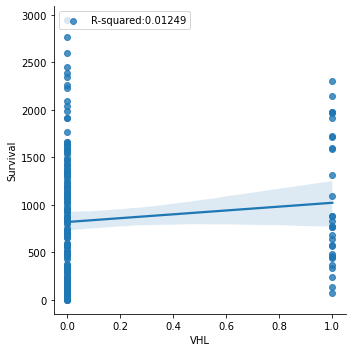

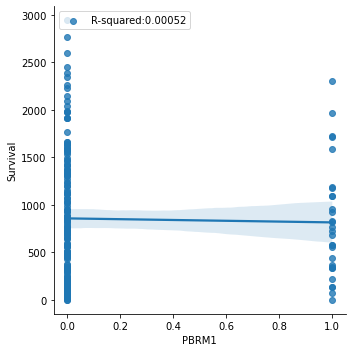

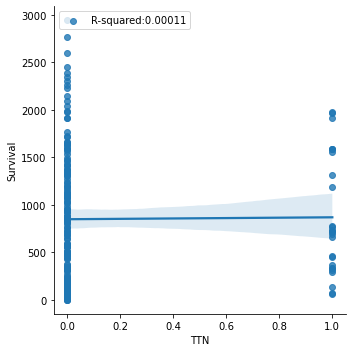

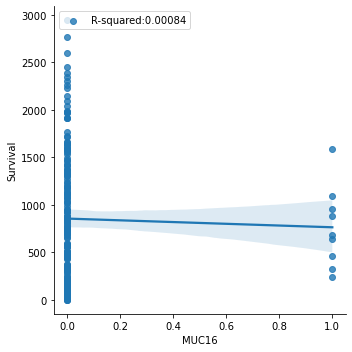

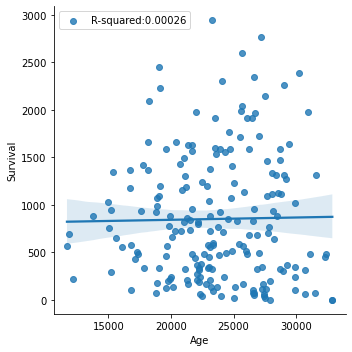

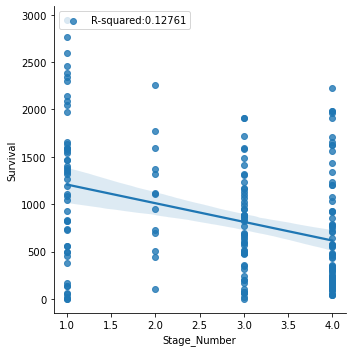

P-val: 0.11886702479347239
Not significant
                            OLS Regression Results                            
Dep. Variable:                    VHL   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.454
Date:                Sun, 11 Dec 2022   Prob (F-statistic):              0.119
Time:                        15:14:56   Log-Likelihood:                -79.283
No. Observations:                 196   AIC:                             162.6
Df Residuals:                     194   BIC:                             169.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept

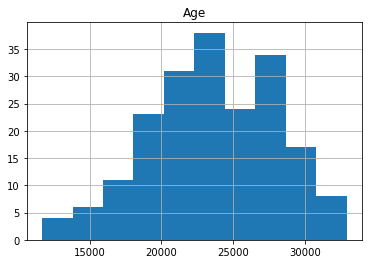

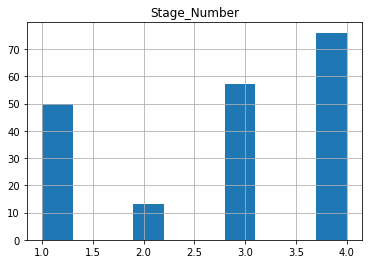

In [57]:
### Workflow

##Create dataframe with mutations marked
TCGA_Data_Mutations = assign_mut(df=TCGA_Data,index='Case UUID',mut_df=[VHL_Case_Mutations,PBRM1_Case_Mutations,TTN_Case_Mutations,MUC16_Case_Mutations])

assign_present_muts(TCGA_Data_Mutations,['VHL','PBRM1','TTN','MUC16'])

TCGA_Data_Mutations = df_to_numeric(TCGA_Data_Mutations,'Survival')
TCGA_Data_Mutations = df_to_numeric(TCGA_Data_Mutations,'Age')

convert_stage_number(TCGA_Data_Mutations,"ajcc_pathologic_tumor_stage")
TCGA_Data_Mutations = df_to_numeric(TCGA_Data_Mutations,'Stage_Number')


##Conduct analyses
disp_linear_models(TCGA_Data_Mutations,['VHL','PBRM1','TTN','MUC16','Age','Stage_Number'],'Survival')

disp_hist(TCGA_Data_Mutations,['Age','Stage_Number'])

generate_mlr(TCGA_Data_Mutations,dep_var=['Survival'],ind_var=['VHL','PBRM1','TTN','MUC16','Age','Stage_Number'])

generate_r2(TCGA_Data_Mutations,'Survival',['VHL','PBRM1','TTN','MUC16','Age','Stage_Number'])

summary_stats(TCGA_Data_Mutations,['VHL','PBRM1','TTN','MUC16','Age','Stage_Number'],'Survival',test_number=6,sig_level=0.05)


